In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.tabular.all import *
from fastai.imports import *
np.set_printoptions(linewidth=130)

path = Path('../input/data-science-salaries-2023')

In [2]:
!pip install -Uqq waterfallcharts treeinterpreter dtreeviz gradio

---

# Objetivo:

Este artigo tem como objetivo estudar árvores de decisão e *random forests* no contexto de *deep learning* e dados tabulares. Para isso, construiremos um modelo com base no dataset [Data Science Salaries 2023](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023), com o qual criaremos uma interface com Gradio para predizer qual salário um cientista de dados receberá.

Criaremos modelos de árvore de decisão usando Regressores, assim como uma Random Forest usando Regressores, já que a variável dependente é um valor contínuo.

### Regressores:

Regressão é o processo de encontrar a correlação entre as váriaveis independentes e uma variável dependente contínua. 
Diferente de classificadores, regressores retornam um float como resultado, pois buscam um valor contínuo. 
Usados para predições de idade, salário, preço, etc. 
</br>Já classificadores retornam valores discretos, dividindo o dataset em classes. Usados para predições dentre um numero limitado de possibilidades conhecidas.

---

In [3]:
df = pd.read_csv(path/'ds_salaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
modes = df.mode().iloc[0]

---

# Limpando os dados

Após a leitura do csv, criamos uma função proc_data para processar os dados de forma a melhor serem processados pelas árvores de decisão, e para serem de mais fácil entendimento, para isso, separamos o dataframe entre colunas categóricas e contíguas, e substituimos algumas abreviações pelas palavras inteiras.

Os dados escolhidos não necessitaram de muita manipulação, por não conter NaN e pelo fato de que árvores de decisão não se importam com outliers ou com o tipo de dado, já que os valores contidos nas colunas são substituídos por valores numéricos que o modelo utilizará internamente. 

# Categóricas ou Contínuas

**Valores categóricos** são valores ou categorias mutuamente exclusivos, os quais se tem que converter para algum valor numérico para que o modelo consiga usá-lo.
</br>**Valores contínuos**, por outro lado, são valores numéricos que representam alguma contagem, em que qualquer tipo de pré processamento não é necessariamente requerido.

---

In [7]:
def proc_data(df):
    df['log_salaries'] = np.log1p(df['salary_in_usd']) #inv = expm1
    df = df.drop(['salary_currency', 'salary', 'salary_in_usd'], axis=1)
    df['experience_level'] = df['experience_level'].replace({'SE':'Senior', 'MI':'Mid Level', 'EN':'Entry Level','EX':'Executive Level'})
    df['employment_type'] = df['employment_type'].replace({'FT':'Full Time', 'CT':'Contractual','PT':'Part Time', 'FL':'Freelancer'})
    df['remote_ratio'] = df['remote_ratio'].replace({100: 'On-site', 0:'Remote', 50:'Hybrid'})
    df['company_size'] = df['company_size'].replace({'L':'Large', 'M':'Medium', 'S':'Small'})
    df['experience_level'] = pd.Categorical(df.experience_level)
    df['employment_type'] = pd.Categorical(df.employment_type)
    df['job_title'] = pd.Categorical(df.job_title)
    df['employee_residence'] = pd.Categorical(df.employee_residence)
    df['remote_ratio'] = pd.Categorical(df.remote_ratio)
    df['company_location'] = pd.Categorical(df.company_location)
    df['company_size'] = pd.Categorical(df.company_size)
    return df

df = proc_data(df).copy()
#tst_df = proc_data(tst_df).copy()

---

Vemos aqui, que as colunas do dataset foram divididas entre categóricas ou contínuas, sendo "work_year" a única coluna contínua.

---

In [8]:
#cats = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
#conts = ['work_year']
dep = 'log_salaries'
conts, cats = cont_cat_split(df, 1, dep_var = dep)
(cats, conts)

(['experience_level',
  'employment_type',
  'job_title',
  'employee_residence',
  'remote_ratio',
  'company_location',
  'company_size'],
 ['work_year'])

In [9]:
exphead = df.experience_level.head()
expcode = df.experience_level.cat.codes.head()
print("Dados normais:\n\n", exphead, "\n\nValores categoricos:\n\n", expcode)

Dados normais:

 0       Senior
1    Mid Level
2    Mid Level
3       Senior
4       Senior
Name: experience_level, dtype: category
Categories (4, object): ['Entry Level', 'Executive Level', 'Mid Level', 'Senior'] 

Valores categoricos:

 0    3
1    2
2    2
3    3
4    3
dtype: int8


---

Temos aqui a representação das categorias por seus valores numéricos. O pandas pega os valores categóricos em ordem alfabética, depois os substitui pelos valores dos seus índices, do tipo int8.

---

In [31]:
to_order = df.employee_residence.cat.codes.unique()
to_order.sort(axis=0)
(df.employee_residence.cat.categories, to_order)

(Index(['AE', 'AM', 'AR', 'AS', 'AT', 'AU', 'BA', 'BE', 'BG', 'BO', 'BR', 'CA',
        'CF', 'CH', 'CL', 'CN', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ',
        'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HN', 'HR', 'HU',
        'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IT', 'JE', 'JP', 'KE', 'KW', 'LT',
        'LU', 'LV', 'MA', 'MD', 'MK', 'MT', 'MX', 'MY', 'NG', 'NL', 'NZ', 'PH',
        'PK', 'PL', 'PR', 'PT', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK', 'TH',
        'TN', 'TR', 'UA', 'US', 'UZ', 'VN'],
       dtype='object'),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int8))

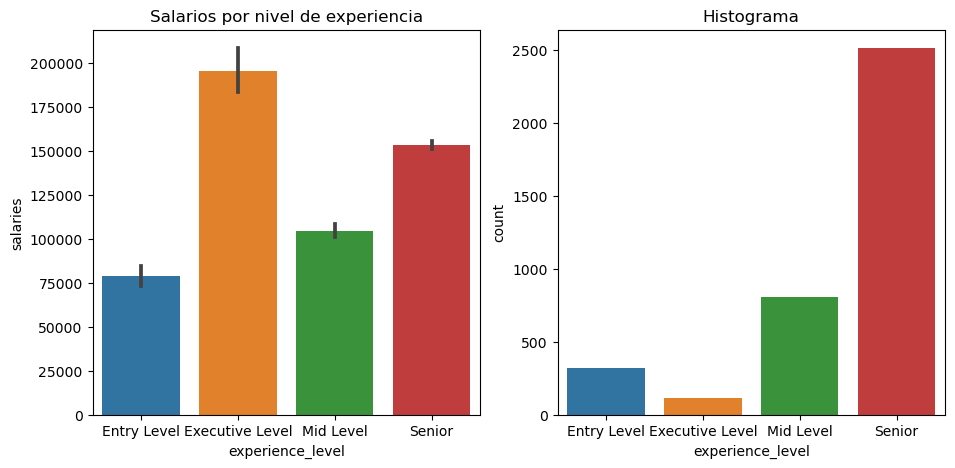

In [32]:
import seaborn as sns

df_copy = df.copy()
df_copy['salaries'] = np.expm1(df.log_salaries)

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df_copy, y='salaries', x="experience_level", ax=axs[0]).set(title="Salarios por nivel de experiencia")
sns.countplot(data=df_copy, x="experience_level", ax=axs[1]).set(title="Histograma");

---

Com o gráfico acima conseguimos ver que há uma grande disparidade nos diferentes salários baseados em nível de experiência. Também há um desbalanceamento nos dados, onde vemos que há muito mais instâncias de "Senior" do das outras categorias.

---

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

np.random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [34]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [36]:
df.log_salaries.median()

11.813037464800539

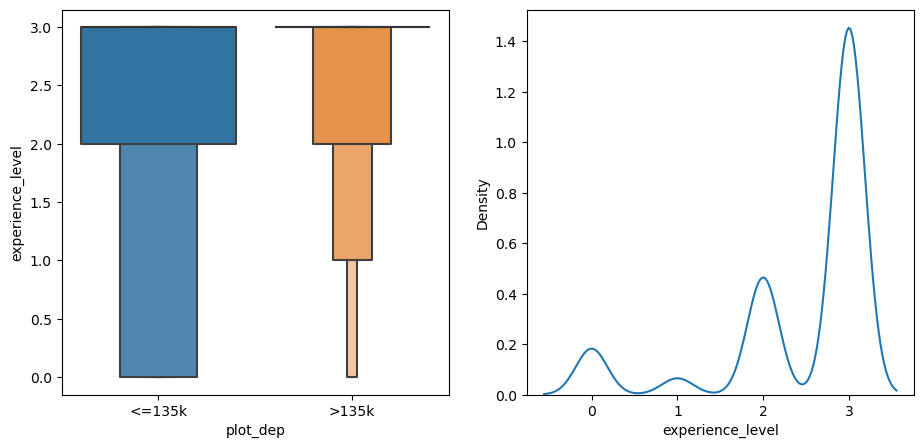

In [37]:
df_exp = trn_df[trn_df.experience_level >= 0]
#df_exp['plot_dep'] = [df_exp.log_salaries > 11]
plot_dep = [df_exp.log_salaries > 11.82]
plot_dep = pd.DataFrame(plot_dep)
plot_dep = plot_dep.transpose()
df_exp['plot_dep'] = plot_dep
df_exp['plot_dep'] = df_exp['plot_dep'].replace({True: '>135k', False:'<=135k'})
fig,axs = plt.subplots(1,2, figsize = (11,5))
sns.boxenplot(data=df_exp, x='plot_dep', y="experience_level", ax=axs[0])
sns.kdeplot(data=df_exp, x="experience_level", ax=axs[1]);
#df_exp.plot_dep.describe()

---

No gráfico acima, podemos interpretar a quantidade de instâncias no dataset, baseado pelo nível de experiência, que recebem menos que 135 mil dólares por ano, ou mais do que isso. Fica claro que de 0.0 - 1.0 (Entry Level), a maioria se encontra na coluna esquerda do gráfico, significando que a maioria recebe menos do que 135 mil.

---

Na árvore abaixo, simples com apenas quatro folhas, podemos ver como a árvore de decisões funciona, por exemplo, que primeiro ela pega a categoria de maior importancia para fazer a primeira decisão (como veremos abaixo).

---

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

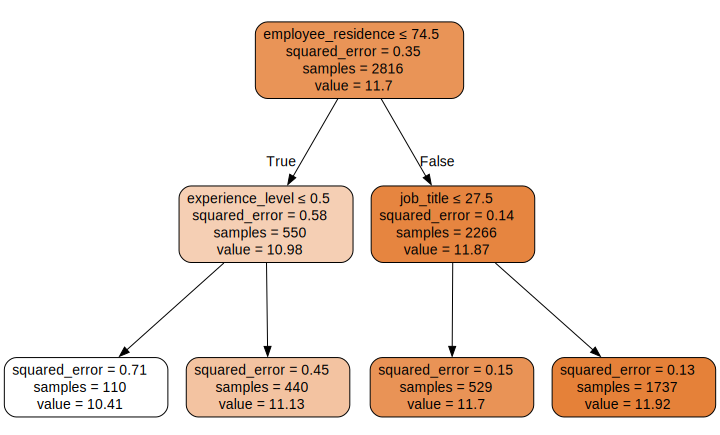

In [39]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(trn_xs, trn_y);

draw_tree(m, trn_xs, size=10, leaves_parallel=True, precision=2)

In [41]:
from dtreeviz.trees import *

In [42]:
m = DecisionTreeRegressor()
m.fit(trn_xs, trn_y);

---

Nesse pedaço do notebook, testamos algumas diferentes maneiras de criar a árvore de decisão, usando diferentes parâmetros, e então medimos seu mean squared error, tanto do dataset de treino quanto do de validação, para melhor entender a diferença que esses parâmetros trazem para pas predições.

---

In [43]:
def r_mse(pred,trn_y): return round(math.sqrt(((pred - trn_y)**2).mean()), 6)
def m_rmse(m, trn_xs, trn_y): return r_mse(m.predict(trn_xs), trn_y)

m_rmse(m, trn_xs, trn_y)

0.264501

In [44]:
m_rmse(m, val_xs, val_y)

0.455904

In [45]:
m.get_n_leaves(), len(trn_xs)

(705, 2816)

In [48]:
m = DecisionTreeRegressor(min_samples_leaf=100)
m.fit(trn_xs, trn_y)
m_rmse(m, trn_xs, trn_y), m_rmse(m, val_xs, val_y), m.get_n_leaves()

(0.427672, 0.452104, 18)

---

Podemos ver aqui uma árvore maior, criada por passar o argumento _min_samples_leaf = 100_, que permite que a árvore de decisão crie subárvores até o ponto de que todas as folhas possam ter um numero perto de 100 samples.

É interessante notar que à esquerda da primeira decisão, isto é, se o valor de employee_residence for menor ou igual a 74, a árvore não se importa com colunas como company_location, job_title, ou outras colunas de menos importância, provavelmente porque a sua contribuição para a predição final é mínima ou por um desbalanceamento nos dados de treinamento.

### Mas como a árvore de decisão escolhe o ponto para fazer o split?
Árvores de decisão são algorítmos gulosos, cada partição vai ser decidida de forma gulosa, de modo que se escolha o ponto em que será maximizado o ganho de informação da árvore, ela faz isso por escolher o ponto em que os dois lados do split terão a máxima homogeneidade, ou a menor impureza. A árvore faz isso utilizando o squared error (variância).

---

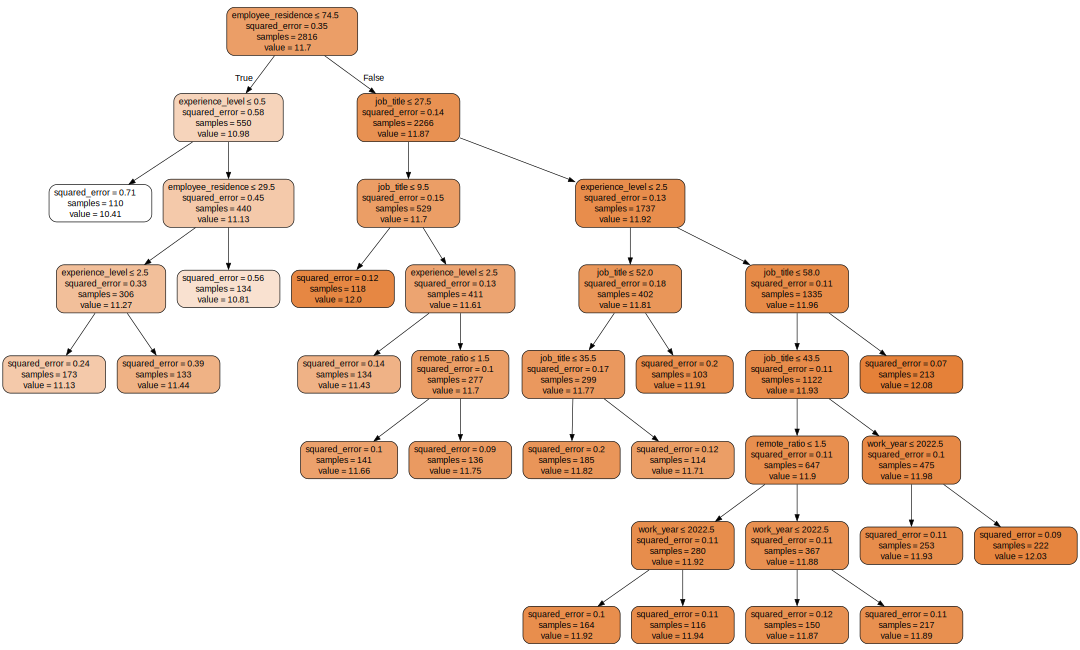

In [53]:
draw_tree(m, trn_xs, size=15, precision=2)

In [47]:
m = DecisionTreeRegressor()
m.fit(trn_xs, trn_y);
m_rmse(m, trn_xs, trn_y), m_rmse(m, val_xs, val_y), m.get_n_leaves()

(0.264501, 0.45347, 705)

In [56]:
def rf(trn_xs, trn_y, n_estimators=40, max_samples=1_400,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(trn_xs, trn_y)

In [57]:
m_forest = rf(trn_xs, trn_y);
m_rmse(m_forest, trn_xs, trn_y), m_rmse(m_forest, val_xs, val_y)

(0.370017, 0.405902)

In [58]:
preds = np.stack([t.predict(val_xs) for t in m_forest.estimators_])
r_mse(preds.mean(0), val_y)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X 

0.405902

---

Definimos preds como sendo a predição de cada árvore da nossa floresta, onde o mse da média deu exatamente o mesmo que o da floresta, depois, plotamos o preds em relação ao número de árvores, para podermos visualizar o impacto que cada árvore adicionada deu no mse do nosso modelo. Observamos que depois de 22 árvores, aproximadamente, a adição de mais árvores fez pouca ou nenhuma diferença.

---

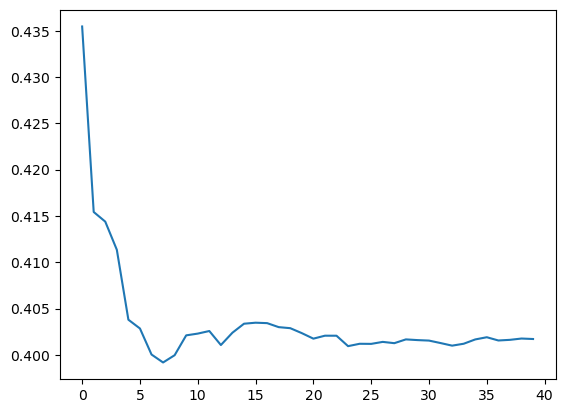

In [28]:
plt.plot([r_mse(preds[:i+1].mean(0), val_y) for i in range(40)]);

In [29]:
r_mse(m_forest.oob_prediction_, trn_y)

0.398262

---

**Out-of-bag error** é uma técnica utilizada por Random Forests para maximizar a sua eficiência. Essa técnica se baseia do fato de que Random Forests não precisam ser separadas entre dados de treino e dados de validação, pois, as diferentes árvores contidas na floresta terão diferentes dados utilizados para seu treino. Então para validar uma árvore, apenas use os dados que não estão sendo utilizados para treinar essa árvore em específico.

---

In [30]:
preds = np.stack([t.predict(val_xs) for t in m_forest.estimators_])
preds.shape

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X 

(40, 939)

In [31]:
preds_std = preds.std(0)
preds_std[:5]

array([0.20643156, 0.0695039 , 0.04160395, 0.11760192, 0.39578852])

In [32]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m_forest.feature_importances_}
                       ).sort_values('imp', ascending=False)

---

### Feature Importance:

Basicamente falando, a importância de uma feature é dada por o número de vezes que ela é utilizada em cada árvore da floresta. Olhando a contribuição que cada variável dá para melhorar o modelo, em cada branch da árvore, e então somar todas essas contribuições por variável.
</br>Mais formalmente, é dada pela média da redução da variância dada por cada feature juntando todas as árvores da floresta. Porém, há uma desvantagem nesse método, pois ele prefere features de alta cardinalidade.

---

In [33]:
fi = rf_feat_importance(m_forest, trn_xs)
fi[:10]

,cols,imp
3,employee_residence,0.418316
5,company_location,0.236279
0,experience_level,0.153710
2,job_title,0.122268
7,work_year,0.032046
4,remote_ratio,0.023071
6,company_size,0.013296
1,employment_type,0.001014


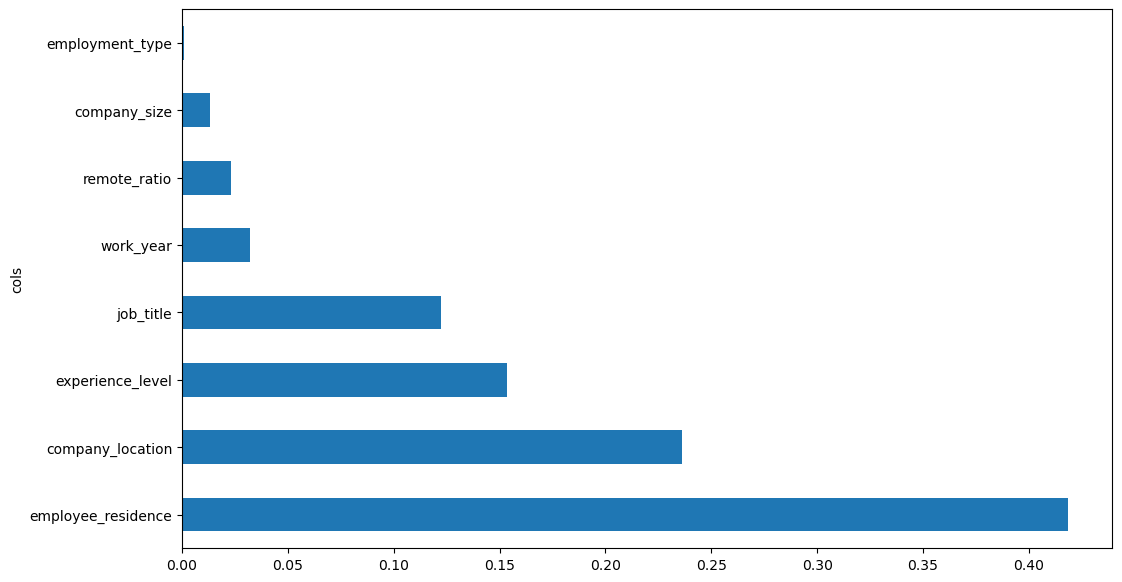

In [34]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

In [37]:
list = df['employee_residence'].value_counts()[:14].index.tolist()

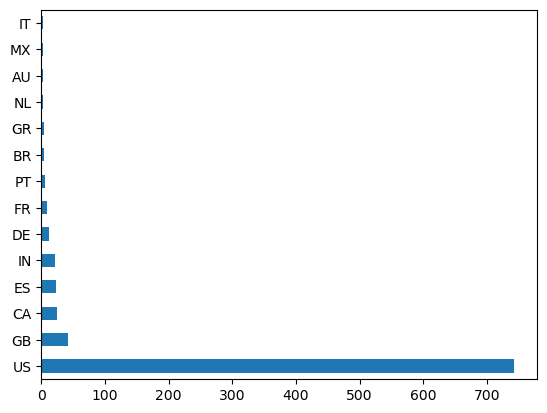

In [38]:
p = val_xs['employee_residence'].value_counts(sort=True)[:14].plot.barh()
plt.yticks(range(len(list)), list);

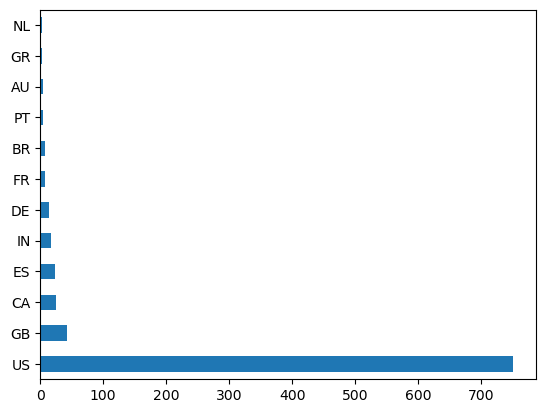

In [39]:
list = df['company_location'].value_counts()[:12].index.tolist()
p = val_xs['company_location'].value_counts(sort=True)[:12].plot.barh()
plt.yticks(range(len(list)), list);

In [40]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [41]:
row = val_xs.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_forest, row.values)
prediction[0], bias[0], contributions[0].sum()

(array([11.86792449]), 11.698307833702954, 0.16961665502785922)

---

Acima temos a separação, por assim dizer, dos itens que calculam a predição. Bias sendo a predição por pegar a média da variável dependente na raíz. </br>Já contribuição nos diz a soma da diferença total que cada variável independente teve para o resultado final. Como podemos visualizar no gráfico abaixo.

---

Abaixo temos um plot, que basicamente mostra a feature importance para este específico row dos dados. A partir do y = 0, vemos que o experience_level e job_title dessa linha de dados causou significante impacto no net final, sendo que employee_residence, company_location e outros trouxeram o net (resultado) um pouco mais pra baixo.

---

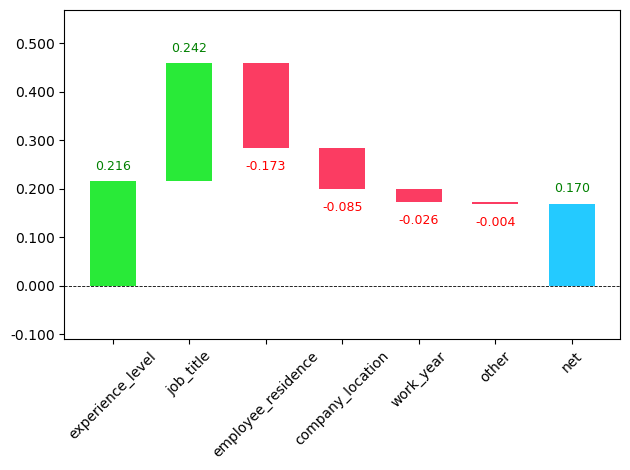

In [42]:
waterfall(val_xs.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

---

A partir daqui, temos um teste do modelo com um row de dados aleatório, que criei para ajudar na implementação do modelo no huggingface, que pode ser acessado em:
</br>
https://huggingface.co/spaces/matheusfga/lesson_6

---

In [57]:
import gradio as gr
import random

list_col = trn_xs.columns
model = m_forest

In [44]:
list_col

Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'work_year'],
      dtype='object')

In [46]:
args = [
    'Senior',
    'Full Time',
    'Data Scientist',
    'US',
    'Remote',
    'US',
    'Large',
    '2023'
    ]

In [47]:
args1 = pd.DataFrame([args], columns=list_col)
args1 = args1.astype("category")
args1.experience_level.cat.codes.head()

0    0
dtype: int8

In [48]:
aux = val_xs.copy()
aux.loc[len(aux)] = args
aux.loc[len(aux) - 1] = aux.loc[len(aux) - 1].astype("category")
aux.tail()

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,work_year
568,3,2,74,75,2,70,1,2023
3297,2,2,25,75,1,70,1,2022
1938,3,2,33,75,2,70,1,2022
1618,2,2,33,75,2,70,1,2023
939,Senior,Full Time,Data Scientist,US,Remote,US,Large,2023


In [49]:
i = 0
for o in list_col:
    aux[o][939] = df[o].cat.categories.get_loc(args[i])
    i += 1
    if i == 7: break

aux.loc[939]

experience_level         3
employment_type          2
job_title               47
employee_residence      75
remote_ratio             2
company_location        70
company_size             0
work_year             2023
Name: 939, dtype: object

In [50]:
#aux.tail()
preds_ar = m_forest.predict(aux)
preds_ar[len(preds_ar) - 1]

11.994177004266573

In [51]:
ans = np.expm1(preds_ar[len(preds_ar) - 1])
ans

161808.8249010795

In [52]:
#aux = aux.apply(lambda x: x.cat.codes)

In [79]:
save_pickle('df.pkl', df)
save_pickle('val_xs.pkl', val_xs)
save_pickle('m_forest.pkl', m_forest)